In [1]:
import gym
import numpy as np
from offsim4rl.envs import gridworld
from offsim4rl.agents import spinup
import torch

No protocol specified


In [2]:
from offsim4rl.data import OfflineDataset, ProbDistribution
from offsim4rl.evaluators.per_state_rejection import PerStateRejectionSampling

In [3]:
class OracleEncoder(object):
    def __init__(self):
        pass
    def encode(self, observations):
        zs = []
        for x, y in observations:
            xx, yy = int(x*5), int(y*5)
            z = xx + 5*yy
            zs.append(z)
        return zs

In [4]:
from offsim4rl.utils.dataset_utils import load_h5_dataset
from offsim4rl.data import SAS_Dataset
from offsim4rl.encoders.homer import HOMEREncoder
from offsim4rl.utils.vis_utils import plot_latent_state_color_map
buffer = load_h5_dataset('../outputs/MyGridNaviCoords-v1_random.h5')

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 32.85it/s]


In [5]:
dataset = OfflineDataset(
    observation_space=gym.spaces.Box(low=0, high=1, shape=(2,)),
    action_space=gym.spaces.Discrete(5),
    action_dist_type=ProbDistribution.Discrete,
    observations=buffer['observations'],
    actions=buffer['actions'].astype(int),
    action_distributions=buffer['infos/probs'],
    rewards=buffer['rewards'],
    next_observations=buffer['next_observations'],
    terminals=buffer['terminals'].astype(bool),
    steps=buffer['infos/steps'].astype(int),
)

2022-08-17 20:32:47,358 - WARNING - root -  Missing episode_ids in experience. Some algorithms may not be compatible with this dataset.


In [6]:
psrs = PerStateRejectionSampling(
    dataset,
    num_states=25,
    encoder=OracleEncoder(),
)

## Learn

In [7]:
# true env for online validation
env = gym.make('MyGridNaviCoords-v1', seed=100000)
env.reset_task(np.array([4, 4]))

array([4, 4])

In [ ]:
for seed in range(10):
    spinup.ppo_revealed(
        env_fn=lambda: psrs, steps_per_epoch=5000, epochs=50, seed=seed, 
        logger_kwargs=dict(output_dir=f'./outputs/grid_psrs_oracle/seed={seed}', exp_name='MyGridNaviCoords-v1_ppo_test_psrs_oracle'), 
        ac_kwargs=dict(hidden_sizes=[32, 32], activation=torch.nn.ReLU), 
        validate=True, val_kwargs=dict(val_env_fn=lambda: env, val_n_episodes=10))

In [21]:
psrs.reset_sampler(seed=1)
seed = 10
spinup.ppo_revealed(
    env_fn=lambda: psrs, steps_per_epoch=5000, epochs=50, seed=seed, 
    logger_kwargs=dict(output_dir=f'./outputs/grid_psrs_oracle/seed={seed}', exp_name='MyGridNaviCoords-v1_ppo_test_psrs_oracle'), 
    ac_kwargs=dict(hidden_sizes=[32, 32], activation=torch.nn.ReLU), 
    validate=True, val_kwargs=dict(val_env_fn=lambda: env, val_n_episodes=10))

Logging data to ./outputs/grid_psrs_oracle/seed=10/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7fb53e927f80>",
    "epochs":	50,
    "exp_name":	"MyGridNaviCoords-v1_ppo_test_psrs_oracle",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<offsim4rl.agents.spinup.utils.logx.EpochLogger object at 0x7fb53eab64d0>":	{
            "epoch_dict":	{},
            "exp_name":	"MyGridNaviCoords-v1_ppo_test_psrs_oracle",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"./outputs/grid_psrs_oracle/seed=10",
            "output_file":	{
                "<_io.TextIOWrapper name='./outputs/grid_psrs_oracle/seed=10/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
  

AssertionError: 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv(f'./outputs/grid_psrs_oracle/seed={seed}/progress.txt', sep='\t')

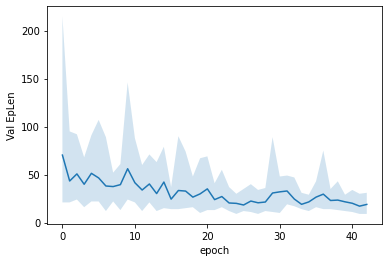

In [19]:
plt.plot(df['AverageVal_EpLen'])
plt.fill_between(df['Epoch'], df['MinVal_EpLen'], df['MaxVal_EpLen'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.show()

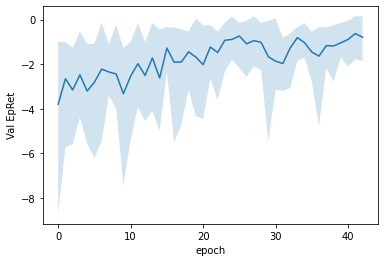

In [20]:
plt.plot(df['AverageVal_EpRet'])
plt.fill_between(df['Epoch'], df['MinVal_EpRet'], df['MaxVal_EpRet'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('Val EpRet')
plt.show()